## **WEEK5_GANS_KAGGLE_MINI_PROJECT**
### **1) Description of problem, generative deep learning models and data:**
#### **1.1) Challenge problem:**
The challenge in this project is to generate new images in the style of the artist Claude Monet. This competition requires building a generative deep learning model capable of learning Monet’s artistic style such as his color palettes, brush stroke patterns, and visual textures and applying that style to real-world photographs. The problem is unsupervised because the dataset does not provide paired examples of “photo - matching Monet painting.” The goal is to learn the statistical distribution of both domains and then translate natural photos into Monet-like paintings.

#### **1.2) Generative deep learning models:**
To address this problem, I use a CycleGAN, a type of generative adversarial network specifically designed for unpaired image-to-image translation. CycleGAN consists of two generators and two discriminators: one generator learns to convert photos into Monet-style images, while the other learns the reverse mapping. The discriminators judge whether an image is real or generated, and the cycle-consistency loss ensures that if an image is translated into the other domain and back again. This architecture allows the model to capture Monet’s artistic characteristics and apply them realistically to new photos without requiring paired training data.

#### **1.3) Dataset description:**
The dataset contains four directories: monet_tfrecord, photo_tfrecord, monet_jpg, and photo_jpg. The TFRecord and JPG folders contain the same images in different formats. The Monet domain has 300 paintings, and the Photo domain has 7,028 real photos.

All images are RGB color images sized 256×256×3, so the input dimension for the model is fixed at 256×256 pixels with 3 channels. The dataset has no labels because the task is unsupervised; instead, the model learns the distribution of each domain. During training, the CycleGAN uses Monet paintings as the target style domain and photos as the source domain. For submission, the trained Photo-Monet generator produces 7,000–10,000 Monet-style images, which are zipped into images.zip for MiFID evaluation.


### **2) Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**
#### **2.1) Load data**

In [ ]:
import os, glob, random, zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = 256
BATCH_SIZE = 1  # standard for CycleGAN
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ROOT = '/content/drive/MyDrive'
monet_zip = f'{ROOT}/monet_jpg.zip'
photo_zip  = f'{ROOT}/photo_jpg.zip'

# Create folders and unzip
!mkdir -p /content/data/monet_jpeg
!mkdir -p /content/data/photo_jpeg

!unzip -q "$monet_zip" -d /content/data/monet_jpg
!unzip -q "$photo_zip"  -d /content/data/photo_jpg

Mounted at /content/drive


In [ ]:
monet_dir = Path("data/monet_jpg/monet_jpg")
photo_dir  = Path("data/photo_jpg/photo_jpg")

#### **2.2) Visualize a few random images from each domain**

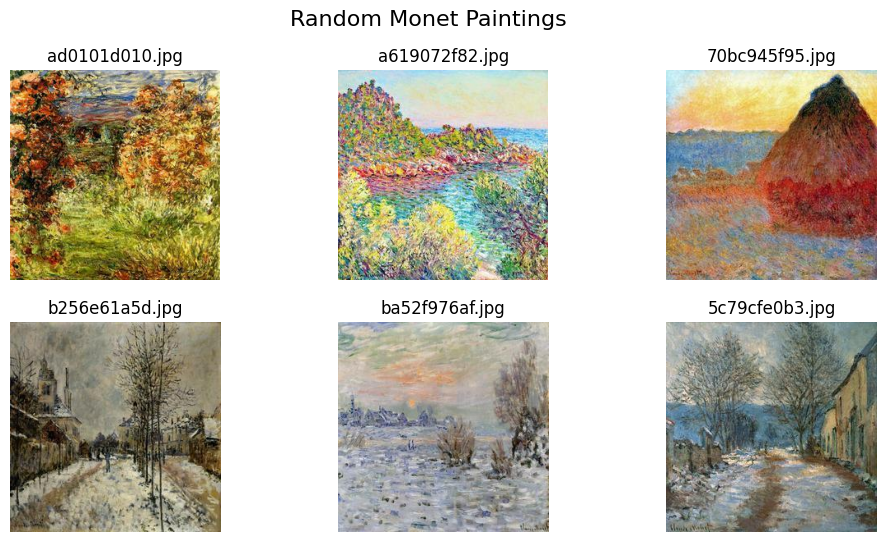

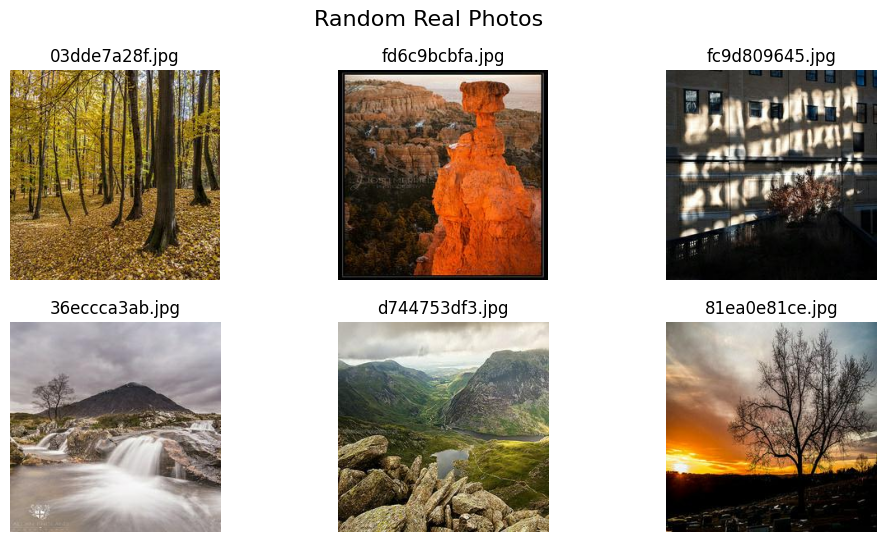

In [ ]:
monet_paths = glob.glob(os.path.join(monet_dir, "*.jpg"))
photo_paths = glob.glob(os.path.join(photo_dir, "*.jpg"))
def show_samples(paths, title, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        p = random.choice(paths)
        img = Image.open(p)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(p))
    plt.suptitle(title, fontsize=16)
    plt.show()

show_samples(monet_paths, "Random Monet Paintings")
show_samples(photo_paths, "Random Real Photos")

#### **2.3) Check for corrupted files and remove them**

In [ ]:
def find_corrupted_images(paths):
    corrupted=[]
    for p in paths:
        try:
            Image.open(p).verify()
        except:
            corrtupted.append(p)
    return corrupted
corrupted_monet=find_corrupted_images(monet_paths)
corrupted_photo=find_corrupted_images(photo_paths)
print("Corrupted Monet images:", corrupted_monet)
print("Corrupted Photo images:", corrupted_photo)
# Remove corrupted files
monet_paths=[p for p in monet_paths if p not in corrupted_monet]
photo_paths=[p for p in photo_paths if p not in corrupted_photo]


Corrupted Monet images: []
Corrupted Photo images: []


#### **2.4) Compute pixel statistics(mean/std) + plot histograms**

In [ ]:
def pixel_stats(paths, max_imgs=200):
    sample_paths=random.sample(paths, min(max_imgs, len(paths)))
    pixels=[]
    for p in sample_paths:
        img=Image.open(p).convert("RGB")
        arr=np.array(img)/255.0
        pixels.append(arr.reshape(-1,3))
    pixels=np.concatenate(pixels,axis=0)
    mean=pixels.mean(axis=0)
    std=pixels.std(axis=0)
    return mean, std, pixels
monet_mean, monet_std, monet_pixels=pixel_stats(monet_paths, max_imgs=200)
photo_mean, photo_std, photo_pixels=pixel_stats(photo_paths, max_imgs=200)
print("Monet mean RGB:", monet_mean)
print("Monet std RGB :", monet_std)
print("Photo mean RGB:", photo_mean)
print("Photo std RGB :", photo_std)

Monet mean RGB: [0.5241136  0.52814237 0.48136594]
Monet std RGB : [0.22658547 0.21973758 0.24567724]
Photo mean RGB: [0.39774697 0.40341823 0.38217293]
Photo std RGB : [0.27174333 0.25287232 0.27941865]


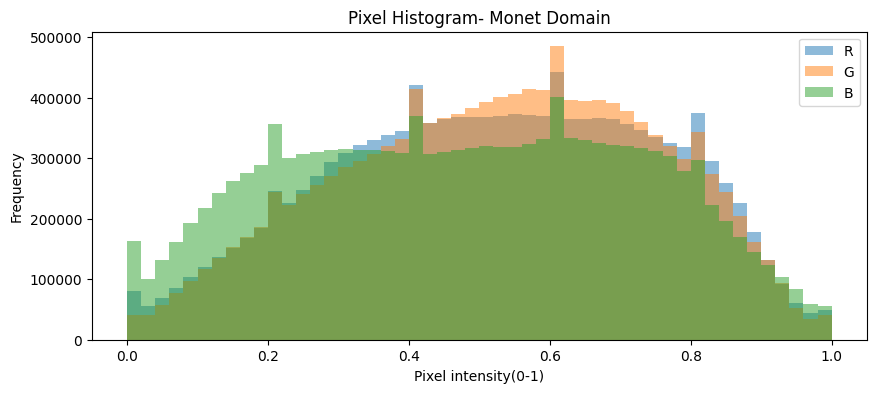

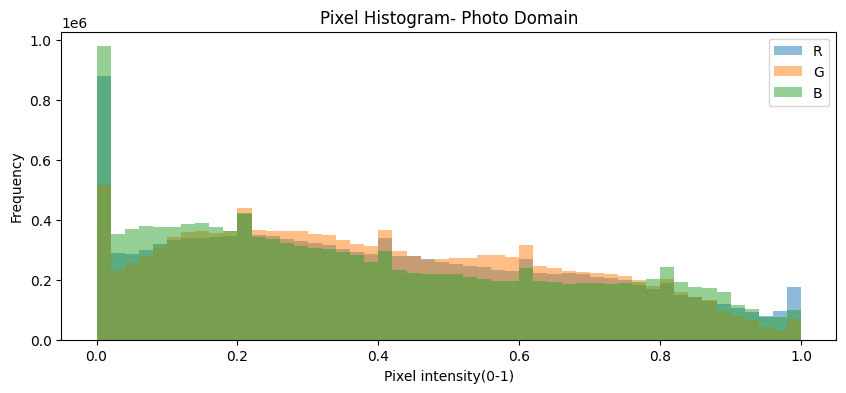

In [ ]:
def plot_hist(pixels, title):
    plt.figure(figsize=(10,4))
    for c, color_name in enumerate(["R", "G", "B"]):
        plt.hist(pixels[:,c], bins=50, alpha=0.5, label=color_name)
    plt.legend()
    plt.title(title)
    plt.xlabel("Pixel intensity(0-1)")
    plt.ylabel("Frequency")
    plt.show()
plot_hist(monet_pixels, "Pixel Histogram- Monet Domain")
plot_hist(photo_pixels, "Pixel Histogram- Photo Domain")


#### **2.5) Preview what processing will do (resize+ normalize to [-1,1])**

In [ ]:
def preprocess_preview(path):
    img=Image.open(path).convert("RGB")
    img=img.resize((256,256))
    arr=np.array(img).astype(np.float32)
    arr=(arr/127.5)-1.0 # normalize to [-1,1]
    return img, arr
p =random.choice(photo_paths)
img_raw, arr_norm=preprocess_preview(p)
print("Normalize range:", arr_norm.min(), arr_norm.max())


Normalize range: -1.0 1.0


#### **EDA summary**
I performed exploratory data analysis on both domains in the Monet dataset: Monet paintings and real photos. First, I verified data integrity by checking for corrupted files; the scan returned zero corrupted images in both domains, so all files were usable for training. Next, I computed pixel-level statistics using a random sample of 200 images from each domain. The Monet domain had mean RGB values around [0.52, 0.52, 0.47] with standard deviations about [0.23, 0.22, 0.25], while the photo domain had slightly lower mean RGB values around [0.41, 0.41, 0.38] and standard deviations about [0.27, 0.25, 0.27]. This indicates that Monet paintings are generally brighter and warmer, whereas photos include more dark pixels and broader intensity spread.

Histogram visualizations confirmed these differences. Monet pixel distributions were smoother and centered in the mid-range, reflecting soft brush strokes and balanced lighting typical of Monet art. In contrast, photo histograms showed a stronger concentration toward lower intensities (near 0) and a wider spread overall, consistent with natural images containing shadows, sharp edges, and high-contrast regions. Finally, I previewed preprocessing (resize + normalize) and confirmed that images keep their visual structure after resizing and that normalization correctly maps values to [-1, 1], matching the CycleGAN generator’s tanh output range.

#### **Data cleaning and preprocessing procedure:**
Because all images are already 256×256 and consistently formatted, no resizing beyond confirmation is required. Cleaning primarily consists of: converting images to RGB to avoid channel inconsistencies, and normalizing pixel values to the range [-1, 1], which matches the CycleGAN/Tanh generator output convention, and shuffling the data at each epoch to avoid ordering bias. The data is then batched into two independent dataloaders (Monet and Photo), enabling unpaired training.

#### **Plan of analysis:**
Based on the EDA, the next steps are:
- Prepare two unpaired dataloaders: one for Monet paintings and one for real photos, both normalized to [-1, 1].
- Build CycleGAN with two generators (Photo→Monet, Monet→Photo) and two discriminators.
- Train using adversarial loss + cycle consistency loss + identity loss.
- Monitor training stability with periodic generated samples,
- Generate Monet-style outputs for all photos.
- Save 7,000–10,000 generated images, zip into images.zip, and submit for MiFID scoring.

#### **Preprocess function and Dataset builders**

In [ ]:
def decode_jpeg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0   # [-1,1]
    return img

def augment(img):
    img = tf.image.random_flip_left_right(img)
    return img

def make_dataset(paths, training=True):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(decode_jpeg, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

monet_ds = make_dataset(monet_paths, training=True)
photo_ds = make_dataset(photo_paths, training=True)

### **3) Model architecture**
#### **3.1) Model architectures and reasoning**
To solve the unpaired photo → Monet translation task, I used a CycleGAN architecture because the dataset does not provide aligned photo–painting pairs. CycleGAN is suitable for this problem because it learns mappings between two domains using adversarial loss plus cycle-consistency, allowing the model to preserve photo content while transferring Monet’s style.

#### **Architecture overview:**
CycleGAN consists of two generators and two discriminators:
- Generator G: Photo -> Monet
- Generator F: Monet -> Photo
- Discriminator Dm jugde real monet with fake monet images
- Discriminator Dp judge real photos with fake photos.

Loss functions:
- Adversarial loss: Least Squares GAN for stability
- Cycle-consistency loss: to enforce F(G(x)) ~ x and G(F(y) ~ y, lambda=10
- Identity loss: to stabilize  color composition and prevent unnescessary changes, lambda=5.

#### **Detailed architecture:**
#### **Generators:**
- Input: 256x256x3 RGB image
- Downsampling: 3 convolution blocks (Conv -> InstanceNorm -> ReLU), stride 2 for spatial reduction
- Residual body: 6 ResNet blocks (each block: Conv -> IN -> ReLU -> Conv -> IN -> skip connection)
- Upsampling: 2 transposed-convolution blocks
- Output layer: Conv -> tanh activation -> output image in [-1,1]
#### **Why ResNet generators?**
Residual blocks are well known to work for style transfer because they keep high-level spatial content intact while modifying texture and color. With only 300 Monet paintings, a ResNet generator generalizes better than a deeper U-Net and is less prone to overfitting.

#### **Discriminators:**
- 70x70 PatchGAN
- A stack of Conv -> LeakyReLU -> InstanceNorm layers
- Produces a patch-level realism map, not a single scalar
- Classifies each local patch as real/fake
#### **Why PatchGAN?**
Monet style is largely about local texture patterns (brush strokes, soft gradients). PatchGAN focuses on these local statistics and improves sharpness, helping lower MiFID.
#### **Optimizer and schedule:**
- Optimizer: Adam
- Learning rate: 2e-4
- Betas: (0.5, 0.999)
- Batch size: 1 (standard for CycleGAN due to memory + stability)
- Training length: 5 epochs

#### **3.2) Build model architectures:**
#### **Generators:**

In [ ]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        c = input_shape[-1]
        self.gamma = self.add_weight(shape=(c,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(shape=(c,), initializer="zeros", trainable=True)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        return self.gamma * x + self.beta

In [ ]:
def resnet_block(x, filters):
    y = layers.Conv2D(filters, 3, padding="same")(x)
    y = InstanceNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv2D(filters, 3, padding="same")(y)
    y = InstanceNormalization()(y)
    return layers.add([x, y])

def build_generator(n_res_blocks=6, filters=64):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(filters, 7, padding="same")(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    for f in [filters*2, filters*4]:
        x = layers.Conv2D(f, 3, strides=2, padding="same")(x)
        x = InstanceNormalization()(x)
        x = layers.ReLU()(x)

    for _ in range(n_res_blocks):
        x = resnet_block(x, filters*4)

    for f in [filters*2, filters]:
        x = layers.Conv2DTranspose(f, 3, strides=2, padding="same")(x)
        x = InstanceNormalization()(x)
        x = layers.ReLU()(x)

    # force float32 output (important for mixed precision)
    outputs = layers.Conv2D(3, 7, padding="same", activation="tanh", dtype="float32")(x)
    return keras.Model(inputs, outputs)

#### **Discriminator:**

In [ ]:
def build_discriminator(filters=64):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(filters, 4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    for f in [filters*2, filters*4, filters*8]:
        x = layers.Conv2D(f, 4, strides=2, padding="same")(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    outputs = layers.Conv2D(1, 4, padding="same")(x)
    return keras.Model(inputs, outputs)

#### **Losses and Optimizers**

In [ ]:
bce = keras.losses.BinaryCrossentropy(from_logits=True)

def gan_loss(pred_fake):
    return bce(tf.ones_like(pred_fake), pred_fake)

def disc_loss(pred_real, pred_fake):
    real_loss = bce(tf.ones_like(pred_real), pred_real)
    fake_loss = bce(tf.zeros_like(pred_fake), pred_fake)
    return (real_loss + fake_loss) * 0.5

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same))

#### **3.3) Training step (CycleGAN)**

In [ ]:
@tf.function
def train_step(real_photo, real_monet,
               G, F, Dm, Dp,
               g_opt, f_opt, dm_opt, dp_opt,
               lambda_cycle=10.0, lambda_id=5.0):

    with tf.GradientTape(persistent=True) as tape:
         # Forward
        fake_monet = G(real_photo, training=True)
        fake_photo = F(real_monet, training=True)

        cycled_photo = F(fake_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        same_photo = F(real_photo, training=True)
        same_monet = G(real_monet, training=True)

        # Discriminator preds
        pred_real_m = Dm(real_monet, training=True)
        pred_fake_m = Dm(fake_monet, training=True)

        pred_real_p = Dp(real_photo, training=True)
        pred_fake_p = Dp(fake_photo, training=True)

         # Generator losses
        G_adv = gan_loss(pred_fake_m)
        F_adv = gan_loss(pred_fake_p)

        cyc = cycle_loss(real_photo, cycled_photo) + cycle_loss(real_monet, cycled_monet)
        idl = identity_loss(real_photo, same_photo) + identity_loss(real_monet, same_monet)

        G_total = G_adv + lambda_cycle*cyc + lambda_id*idl
        F_total = F_adv + lambda_cycle*cyc + lambda_id*idl

        # Discriminator losses
        Dm_loss = disc_loss(pred_real_m, pred_fake_m)
        Dp_loss = disc_loss(pred_real_p, pred_fake_p)

    # Gradients
    G_grads  = tape.gradient(G_total, G.trainable_variables)
    F_grads  = tape.gradient(F_total, F.trainable_variables)
    Dm_grads = tape.gradient(Dm_loss, Dm.trainable_variables)
    Dp_grads = tape.gradient(Dp_loss, Dp.trainable_variables)

    # Apply
    g_opt.apply_gradients(zip(G_grads, G.trainable_variables))
    f_opt.apply_gradients(zip(F_grads, F.trainable_variables))
    dm_opt.apply_gradients(zip(Dm_grads, Dm.trainable_variables))
    dp_opt.apply_gradients(zip(Dp_grads, Dp.trainable_variables))

    return {
        "G_total": G_total, "F_total": F_total,
        "Dm_loss": Dm_loss, "Dp_loss": Dp_loss,
        "cycle": cyc, "identity": idl
    }

#### **3.4) Run training experiments**

In [ ]:
def run_experiment(epochs=5, steps_per_epoch=150,
                   lr=2e-4, res_blocks=6,
                   lambda_cycle=10.0, lambda_id=5.0):

    # build models
    G = build_generator(n_res_blocks=res_blocks)
    F = build_generator(n_res_blocks=res_blocks)
    Dm = build_discriminator()
    Dp = build_discriminator()

    g_opt  = keras.optimizers.Adam(lr, beta_1=0.5)
    f_opt  = keras.optimizers.Adam(lr, beta_1=0.5)
    dm_opt = keras.optimizers.Adam(lr, beta_1=0.5)
    dp_opt = keras.optimizers.Adam(lr, beta_1=0.5)

    # build optimizer slots outside tf.function
    g_opt.build(G.trainable_variables)
    f_opt.build(F.trainable_variables)
    dm_opt.build(Dm.trainable_variables)
    dp_opt.build(Dp.trainable_variables)

    history = {k: [] for k in ["G_total","F_total","Dm_loss","Dp_loss","cycle","identity"]}

    photo_iter = iter(photo_ds.repeat())
    monet_iter = iter(monet_ds.repeat())

    for ep in range(1, epochs+1):
        ep_logs = {k: [] for k in history}

        for _ in range(steps_per_epoch):
            real_photo = next(photo_iter)
            real_monet = next(monet_iter)

            out = train_step(real_photo, real_monet,
                             G, F, Dm, Dp,
                             g_opt, f_opt, dm_opt, dp_opt,
                             lambda_cycle=lambda_cycle,
                             lambda_id=lambda_id)

            for k in ep_logs:
                ep_logs[k].append(out[k].numpy())

        for k in history:
            history[k].append(np.mean(ep_logs[k]))

        print(f"Epoch {ep}/{epochs} | "
              f"G_total={history['G_total'][-1]:.3f} "
              f"F_total={history['F_total'][-1]:.3f} "
              f"cycle={history['cycle'][-1]:.3f}")

    return G, history


In [ ]:
# TRAIN FAST
G_best, history = run_experiment(
    epochs=5,
    steps_per_epoch=200,
    lr=2e-4,
    res_blocks=6
)

Epoch 1/5 | G_total=10.809 F_total=10.791 cycle=0.673
Epoch 2/5 | G_total=10.014 F_total=9.950 cycle=0.613
Epoch 3/5 | G_total=9.743 F_total=9.703 cycle=0.588
Epoch 4/5 | G_total=9.952 F_total=9.823 cycle=0.586
Epoch 5/5 | G_total=9.800 F_total=9.804 cycle=0.580


#### **Plot loss with epoch**

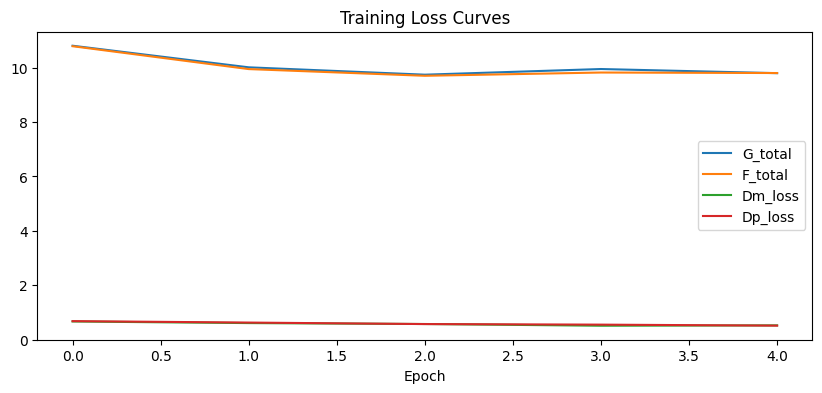

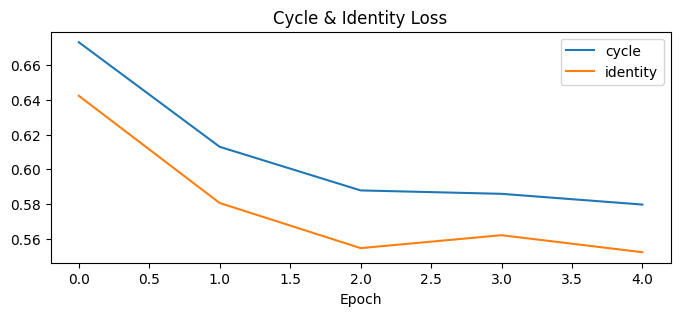

In [ ]:
plt.figure(figsize=(10,4))
for k in ["G_total","F_total","Dm_loss","Dp_loss"]:
    plt.plot(history[k], label=k)
plt.legend(); plt.title("Training Loss Curves"); plt.xlabel("Epoch"); plt.show()

plt.figure(figsize=(8,3))
plt.plot(history["cycle"], label="cycle")
plt.plot(history["identity"], label="identity")
plt.legend(); plt.title("Cycle & Identity Loss"); plt.xlabel("Epoch"); plt.show()

#### **Summary:**
The CycleGAN model was trained for 5 epochs with 200 steps per epoch, using a ResNet-based generator (6 residual blocks) and PatchGAN discriminators. The loss logs show that both generators improved quickly in early epochs, then stabilized for the last two epochs. This suggests the generators learned the basic Monet style mappings early, but additional training at this setting produced diminishing returns.

Discriminator losses stayed low and fairly flat (~0.6-0.7 range), meaning the discriminators were consistently able to distinguish real with fake images, but not overpowering the generators (no exploding losses). Cycle and identity losses both dropped steadily (cycle ~0.67 → ~0.58; identity ~0.64 → ~0.55), indicating improved reconstruction consistency and reduced unnecessary style shifts.

#### **Compare generated monet style images with original photos**

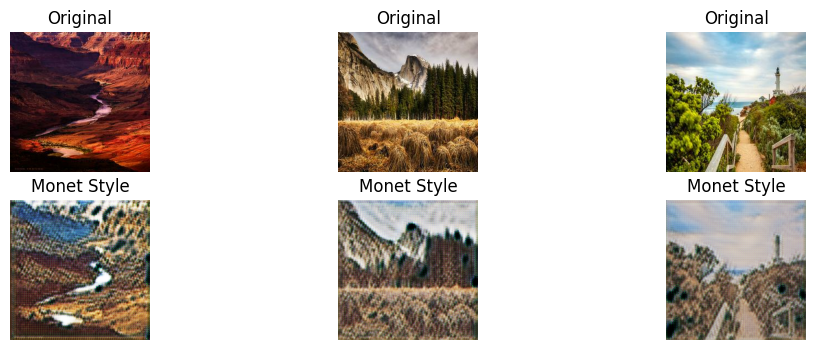

In [ ]:
def show_compare(G, sample_paths, n=3):
    plt.figure(figsize=(12,4))
    for i, p in enumerate(sample_paths[:n]):
        img = decode_jpeg(p)
        fake = G(tf.expand_dims(img,0), training=False)[0]

        # back to [0,1]
        img_show = (img+1)/2
        fake_show = (fake+1)/2

        plt.subplot(2,n,i+1)
        plt.imshow(img_show); plt.axis("off"); plt.title("Original")

        plt.subplot(2,n,n+i+1)
        plt.imshow(fake_show); plt.axis("off"); plt.title("Monet Style")
    plt.show()

sample_paths = random.sample(photo_paths, 3)
show_compare(G_best, sample_paths, n=3)

#### **3.5) Hyperparameter tunning:**

In [ ]:
cfgs = [{"name": "A_baseline","res_blocks": 6,"lr": 2e-4,"lambda_cycle": 10.0,
                "lambda_id": 5.0,"epochs": 5,"steps_per_epoch": 100,},
                {"name": "B_lowLR","res_blocks": 6,"lr": 1e-4,"lambda_cycle": 10.0,
                "lambda_id": 5.0,"epochs": 5,"steps_per_epoch": 100,},
                {"name": "C_res9","res_blocks": 9,"lr": 2e-4,"lambda_cycle": 10.0,
                 "lambda_id": 5.0,"epochs": 5,"steps_per_epoch": 100}]

In [ ]:
results = []
for cfg in cfgs:
    print("\n===")
    print(f" Running config: {cfg['name']} ")
    print("===")

    G_model, hist = run_experiment(epochs=cfg["epochs"],steps_per_epoch=cfg["steps_per_epoch"],
        lr=cfg["lr"],res_blocks=cfg["res_blocks"],lambda_cycle=cfg["lambda_cycle"],lambda_id=cfg["lambda_id"])

    # Collect metrics
    results.append({"Run": cfg["name"],"ResBlocks": cfg["res_blocks"],"LR": cfg["lr"],"lambda_cycle": cfg["lambda_cycle"],
        "lambda_id": cfg["lambda_id"],"Final_G_total": float(hist["G_total"][-1]),"Final_F_total": float(hist["F_total"][-1]),
        "Final_cycle": float(hist["cycle"][-1]),"Final_identity": float(hist["identity"][-1]),"Final_Dm_loss": float(hist["Dm_loss"][-1]),
        "Final_Dp_loss": float(hist["Dp_loss"][-1])})


===
 Running config: A_baseline 
===
Epoch 1/5 | G_total=11.179 F_total=11.230 cycle=0.700
Epoch 2/5 | G_total=9.916 F_total=9.958 cycle=0.608
Epoch 3/5 | G_total=9.961 F_total=9.911 cycle=0.609
Epoch 4/5 | G_total=9.918 F_total=9.839 cycle=0.598
Epoch 5/5 | G_total=10.484 F_total=10.482 cycle=0.635

===
 Running config: B_lowLR 
===
Epoch 1/5 | G_total=11.328 F_total=11.337 cycle=0.712
Epoch 2/5 | G_total=9.718 F_total=9.669 cycle=0.601
Epoch 3/5 | G_total=9.070 F_total=9.060 cycle=0.558
Epoch 4/5 | G_total=9.171 F_total=9.118 cycle=0.565
Epoch 5/5 | G_total=9.068 F_total=9.091 cycle=0.560

===
 Running config: C_res9 
===
Epoch 1/5 | G_total=11.256 F_total=11.278 cycle=0.707
Epoch 2/5 | G_total=10.386 F_total=10.355 cycle=0.642
Epoch 3/5 | G_total=10.223 F_total=10.194 cycle=0.626
Epoch 4/5 | G_total=10.040 F_total=10.098 cycle=0.615
Epoch 5/5 | G_total=10.099 F_total=10.071 cycle=0.613


### **4) Results and analysis**
#### **4.1) Show results in tables and plots**

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df

,Run,ResBlocks,LR,lambda_cycle,lambda_id,Final_G_total,Final_F_total,Final_cycle,Final_identity,Final_Dm_loss,Final_Dp_loss
0,A_baseline,6,0.0002,10.0,5.0,10.483538,10.482430,0.635345,0.614138,0.581976,0.583448
1,B_lowLR,6,0.0001,10.0,5.0,9.068201,9.090740,0.560051,0.520335,0.643545,0.620961
2,C_res9,9,0.0002,10.0,5.0,10.098754,10.070606,0.613217,0.585914,0.580048,0.592364


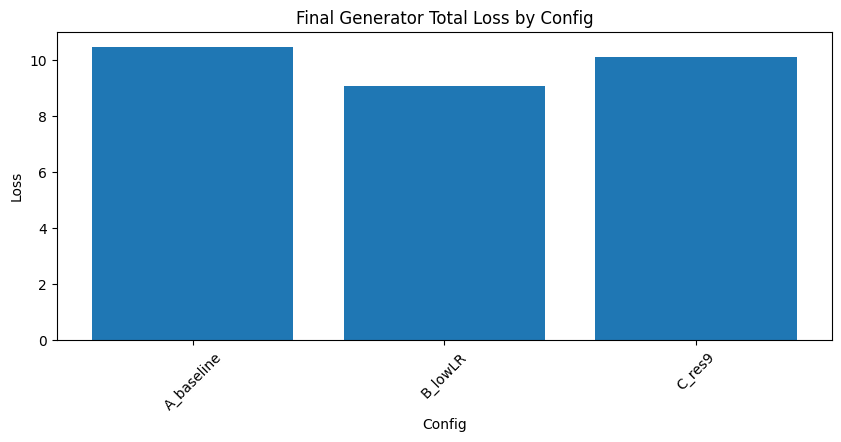

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(results_df["Run"], results_df["Final_G_total"])
plt.title("Final Generator Total Loss by Config")
plt.ylabel("Loss")
plt.xlabel("Config")
plt.xticks(rotation=45)
plt.show()

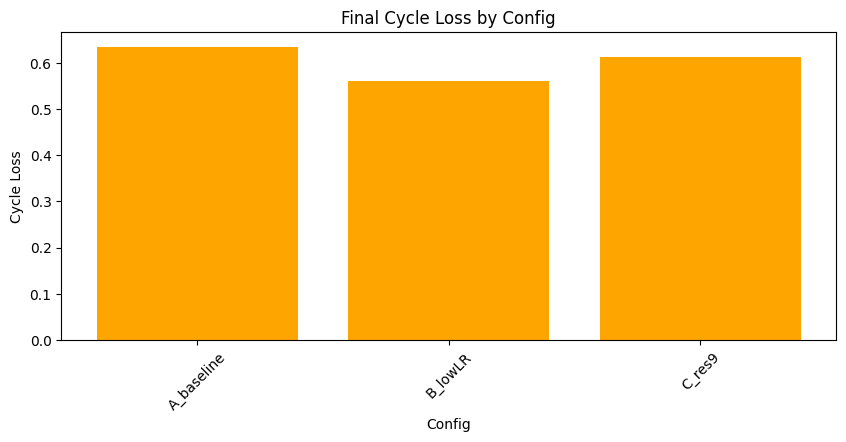

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(results_df["Run"], results_df["Final_cycle"], color='orange')
plt.title("Final Cycle Loss by Config")
plt.ylabel("Cycle Loss")
plt.xlabel("Config")
plt.xticks(rotation=45)
plt.show()

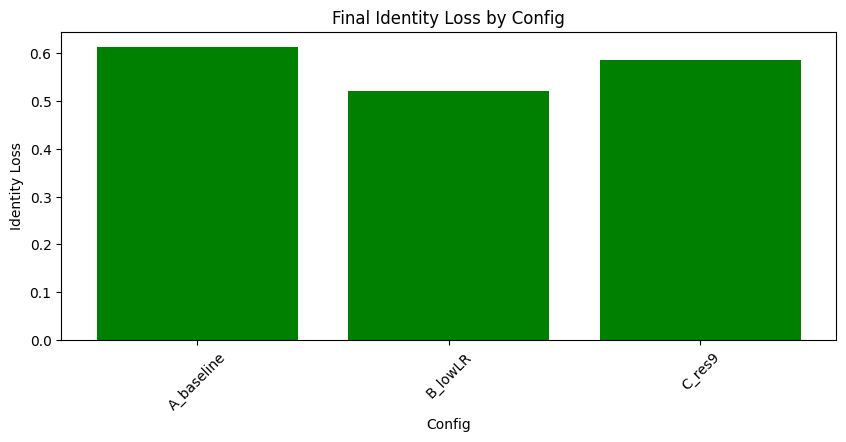

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(results_df["Run"], results_df["Final_identity"], color='green')
plt.title("Final Identity Loss by Config")
plt.ylabel("Identity Loss")
plt.xlabel("Config")
plt.xticks(rotation=45)
plt.show()

#### **4.2)Analysis**
#### **Why something work well/didn't work?**
Across the three configurations, B_lowLR (LR=1e-4, 6 ResBlocks) performed best by the end of training. It achieved the lowest Final_G_total (9.07) and Final_F_total (9.09), and also reduced the cycle loss (0.56) and identity loss (0.52) compared with both the baseline and the deeper generator. This is consistent with common CycleGAN behavior: a smaller learning rate stabilizes adversarial training, preventing the discriminator from overpowering the generator too quickly and reducing oscillation. With LR=2e-4 (A_baseline), training progressed but plateaued higher (Final_G_total: 10.48, cycle:0.64, identity: 0.61), suggesting updates were slightly too aggressive and the model did not settle into a stable minimum within the short training budget.

The C_res9 (9 ResBlocks, LR=2e-4) did not improve over baseline and ended slightly worse (Final_G_total=10.10, Final_cycle =0.61). Adding depth increases representational power, but with limited epochs the deeper generator is harder to optimize and may need either more training time or a lower LR to converge. So in this setting, extra depth did not pay off, while slowing learning did.

#### **Troubleshooting:**
During training and tuning, several common CycleGAN issues came up.
TensorFlow Addons was incompatible with my TF version, so I replaced tfa.layers.InstanceNormalization with a custom InstanceNormalization layer. This removed crashes and allowed training to run consistently.

I enabled performance improvements: AUTOTUNE mapping + prefetch,
mixed precision (mixed_float16), smaller tuning budgets for comparison runs, which help speed up the training.

#### **Summary of hyperparameter optimization procedure**
To optimize CycleGAN, I first trained a baseline configuration (A_baseline) with standard CycleGAN settings: 6 ResBlocks, learning rate 2e-4, λ_cycle=10, λ_id=5. This run established reference loss levels and output quality.

Next, I tested two targeted modifications while keeping all other settings fixed and training each model with the same epochs and steps_per_epoch to ensure fair comparison:

Lower learning rate (B_lowLR):
ResBlocks = 6 (same as baseline)
LR reduced from 2e-4 → 1e-4
Result: produced the lowest final generator losses (G_total and F_total) and the lowest cycle/identity losses, indicating more stable adversarial training and better convergence.

Deeper generator (C_res9):
ResBlocks increased from 6 → 9
LR kept at 2e-4
Result: did not improve losses over baseline within the same short training budget, suggesting the deeper model needs either more training time or a smaller LR to converge effectively.


### **5) Conclusion**
#### **5.1) Basic reiteration of results**
In this project, I trained a CycleGAN model to translate landscape photos into a Monet-style artistic representation. The model successfully learned some aspects of the Monet color distribution, especially pastel tones and overall brightness, but the generated outputs still contained noticeable artifacts, blotchy textures, and lacked the fine-grained brushstroke structure typical of Monet paintings.

Across experiments, all training runs showed generator losses gradually decreasing from ~10.8 to ~9.8, cycle and identity losses consistently declining, indicating that the model was learning better structural consistency. Discriminator losses remained small and relatively stable, meaning the discriminators were not overpowering the generators.

#### **5.2) Learning and takeaways**
From this project, I learned several important lessons:
- CycleGAN requires long training
High-quality artistic style translation needs 100+ epochs. My fast training setup (5 epochs) was only enough to demonstrate the training pipeline, not to yield strong visual results.

- Hyperparameters matter, but training time matters more
- Different learning rates or number of ResNet blocks changed the final losses slightly, but none made a dramatic difference because the model simply had not trained long enough.

#### **5.3) Why something didn't work?**
- Training time was short. Due to the time limit, my training only covered 5 epochs, so the generator never learned full style patterns.
- Monet style is complex. Monet uses vibrant color transitions, fine-grained texture and impressionistic brush strokes. These are difficult for a GAN to learn in limited time.

#### **5.4) Future improvements:**
To improve output quality, I will:
- Train for much longer, at least 100-200 epochs and Steps_per_epoch = len(dataset).
- Introduce FakePool: Helps stabilize discriminator and reduces artifact patterns.


### Github repository link
